# Code that runs and produces (n,nprime) histograms for Pois model and NegBin->Pois models of P(n|f)

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from pylab import rcParams
mpl.rc("figure", facecolor="gray")
rcParams['font.size']=12
rcParams['lines.markersize']=7
rcParams['figure.figsize'] = 8,8
rcParams['lines.markeredgewidth'] = 2
import numpy as np
import time
from copy import deepcopy
import sys
from functools import partial
from scipy.optimize import minimize
import pandas as pd
import pylab as pl
import os
import itertools
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#add path to all scripts
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
import infer_diffexpr_lib
reload(infer_diffexpr_lib)
from infer_diffexpr_lib import get_sparserep,import_data,plot_n1_vs_n2,add_ticks

In [16]:
parvernull = 'v1__case0'
rootpath = '../../'
path = rootpath + 'output/outdata_all/'
daynull="0"#"pre0"
day="0"
donor='S1'
dataset_pair=(donor+'_'+daynull+'_F1', donor+'_'+day+'_F2')
headerline=0
colnames = [u'Clone fraction',u'Clone count',u'N. Seq. CDR3',u'AA. Seq. CDR3'] 

datarootpath='../../Yellow_fever/prepostvaccine/' 
mincount=0
maxcount=np.Inf
runstr = 'min' + str(mincount) + '_max' + str(maxcount) + '_' + parvernull
outpath = path + dataset_pair[0] + '_' + dataset_pair[1] + '/' + runstr + '/'
initparas=np.load(path + donor+'_0_F1_'+donor+'_0_F2/' + runstr + '/'+'optparas.npy')
Nclones_samp,subset=import_data(datarootpath,dataset_pair[0]+'_.txt',dataset_pair[1]+'_.txt',mincount,maxcount,colnames,colnames)
counts_d=subset.loc[:,['Clone_count_1','Clone_count_2']]
#transform to sparse representation
indn1_d,indn2_d,countpaircounts_d,unicountvals_1_d,unicountvals_2_d,NreadsI_d,NreadsII_d=get_sparserep(counts_d)       
Nsamp=np.sum(countpaircounts_d)

In [5]:
print('$N_\mathrm{samp}='+str(Nclones_samp)+r'$, $N=10^9$, sampling efficincy:'+str(Nclones_samp/float(10**9))) #blood sampling efficiency
print('$N_\mathrm{reads}='+str(NreadsI_d)+r'$, $M_\textrm{cells}=10^{6.8}$, sequencing efficincy:'+str(NreadsI_d/10**6.8)) #blood sampling efficiency

$N_\mathrm{samp}=1037500$, $N=10^9$, sampling efficincy:0.0010375
$N_\mathrm{reads}=959202.0$, $M_\textrm{cells}=10^{6.8}$, sequencing efficincy:0.15202327199950855


## Data plot

1037500 531432 461624 44444
0.5122236144578314 0.4449387951807229 0.042837590361445785


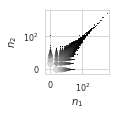

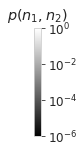

In [20]:
sns.set_style("whitegrid", {'axes.grid' : True})
# plot_n1_vs_n2(subset.loc[:,['Clone_count_1','Clone_count_2']],'null_n1_v_n2_'+parvernull+'_data',outpath,True)
plot_n1_vs_n2(subset.loc[:,['Clone_count_1','Clone_count_2']],'','',False)

num_x0_data=subset.loc[subset.Clone_count_2==0,['Clone_count_1','Clone_count_2']].shape[0]
num_0x_data=subset.loc[subset.Clone_count_1==0,['Clone_count_1','Clone_count_2']].shape[0]
num_xx_data=np.sum(countpaircounts_d)-num_x0_data-num_0x_data
print(str(np.sum(countpaircounts_d))+' '+str(num_x0_data)+' '+str(num_0x_data)+' '+str(num_xx_data))
print(str(num_x0_data/float(np.sum(countpaircounts_d)))+' '+str(num_0x_data/float(np.sum(countpaircounts_d)))+' '+str(num_xx_data/float(np.sum(countpaircounts_d))))

fig = pl.figure(figsize=(0.1, 10))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
# ax1.fontname('arial')
cmap = mpl.cm.gray
norm = mpl.colors.Normalize(vmin=np.log10(1/float(np.sum(countpaircounts_d))), vmax=0)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                            norm=norm,
                            orientation='vertical',
                            ticks=[-6,-4,-2,0.])
fig.suptitle(r'$p(n_{1},n_{2})$')
cb1.set_ticklabels([r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$'])#,r'$10^-3$',r'$10^-2$',r'$10^-1$'])
# cb1.set_ticklabels(cb1.get_ticks(), 'Arial')
# cb1.ax.tick_params(font='arial')
# font = mpl.font_manager.FontProperties(family='arial')
# text.set_font_properties(font)
fig.savefig('fig1_colorbar.pdf',format= 'pdf',dpi=1000, bbox_inches='tight')

## NB->Pois plot

In [4]:
def constr_fn(paras,NreadsI_d,NreadsII_d,unicountvals_1_d,unicountvals_2_d,indn1_d,indn2_d,countpaircounts_d,case,caseout): #additional inputs???
    NreadsI=NreadsI_d
    NreadsII=NreadsII_d
    repfac=NreadsII/NreadsI
    alpha_rho = paras[0]
    Nreadsvec=(NreadsI,NreadsII)
    if case<2:
#         m_total=float(np.power(10, paras[3]))
        m_total=np.power(10,paras[3])
        r_c1=NreadsI/m_total 
        r_c2=repfac*r_c1     
        r_cvec=(r_c1,r_c2)
        fmin=np.power(10,paras[4])
    else:
        fmin=np.power(10,paras[3])
#     beta_mv= float(np.power(10,paras[1]))
    beta_mv= paras[1]
    alpha_mv=paras[2]
    #fmin=1e-11 #13  #-11 #Smallest frequency is of singleton from total number of lymphocytes in body, 10^11.

    fmax=1e0
    freq_nbins=500
    logfvec=np.linspace(np.log10(fmin),np.log10(fmax),freq_nbins)
    fvec=np.power(10,logfvec)  
    rhovec=np.power(fvec,alpha_rho)
    logfvec=np.log(fvec)
    integ=np.exp(np.log(rhovec)+logfvec)
    normconst=np.dot(np.diff(logfvec)/2.,integ[1:]+integ[:-1])
    rhovec=rhovec/normconst 
    rhofvec=rhovec
    
    logrhofvec=np.log(rhofvec)
    logfvec=np.log(fvec)
    dlogf=np.diff(logfvec)/2.
    
    for it in range(2):
        mvec=np.arange(500)
        Pn_f=np.zeros((len(fvec),))
        if case==0:
            mean_m=m_total*fvec
            var_m=mean_m+beta_mv*np.power(mean_m,alpha_mv)
            Poisvec=PoisPar(mvec*r_cvec[it],np.arange(2))[:,0]
            for f_it in range(len(fvec)):
                NBvec=NegBinPar(mean_m[f_it],var_m[f_it],mvec)
                Pn_f[f_it]=np.dot(NBvec,Poisvec) 
        elif case==2:
            mean_m=Nreadsvec[it]*fvec
            var_m=mean_m+beta_mv*np.power(mean_m,alpha_mv)
            m=mean_m
            v=var_m
            p = 1-m/v#1-tmp
            r = m*m/v/p#tmp*m/p
            Pn_f=np.exp(r*np.log(m/v))
        
        if it==0:
            logPn1_f=np.log(Pn_f)#[:,uinds1]) #throws warning
            #if isinstance(svec,np.ndarray): 		#when only computin Pn_f once
            #smaxind=(len(svec)-1)/2
            ##logPn1_f=logPn1_f[f2s_step*smaxind+shift_s_step:-f2s_step*smaxind+shift_s_step,:]
        else:
            logPn2_f=np.log(Pn_f)#[:,uinds2])
    
    integ=np.exp(logrhofvec+2*logfvec)
    avgf_ps=np.dot(dlogf,integ[:-1]+integ[1:])
    if caseout==0:
        integ=np.exp(logPn1_f+logPn2_f+logrhofvec+logfvec)
        Pn0n0=np.dot(dlogf,integ[1:]+integ[:-1])
        avgf_null_pair=np.exp(np.log(1-Pn0n0)-np.log(np.sum(countpaircounts_d)))
        return avgf_ps-avgf_null_pair
    else:
        integ=np.exp(logPn1_f+logrhofvec+logfvec)
        Pn0=np.dot(dlogf,integ[1:]+integ[:-1])
        avgf_null_firstcount=np.exp(np.log(1-Pn0)-np.log(np.sum(countpaircounts_d[unicountvals_1_d[indn1_d]>0])))
        return avgf_ps-avgf_null_firstcount

In [5]:
from infer_diffexpr_lib import constr_fn
from infer_diffexpr_lib import get_Pn1n2_s

In [7]:
NreadsI=NreadsI_d
NreadsII=NreadsII_d
repfac=NreadsII/NreadsI
nfbins=500
case=0
condict={'type':'eq','fun':constr_fn,'args': (NreadsI_d,NreadsII_d,unicountvals_1_d,unicountvals_2_d,indn1_d,indn2_d,countpaircounts_d,case,'float64')}
st=time.time()
partialobjfunc=partial(get_Pn1n2_s,svec=-1,unicountvals_1=unicountvals_1_d, unicountvals_2=unicountvals_2_d, NreadsI=NreadsI_d, NreadsII=NreadsII_d, nfbins=nfbins,repfac=repfac,indn1=indn1_d ,indn2=indn2_d,countpaircounts_d=countpaircounts_d,case=case,freq_dtype='float64')
initparas = np.asarray([[-2.19629167,  2.40560287,  1.10944424,  6.61597503, -9.32561711]])
Nfeval = 1
def callbackF(Xi):
    global Nfeval
    print('{0: 4d} {1: 3.6f} {2: 3.6f} {3: 3.6f} {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4]))
    Nfeval += 1
nullfunctol=1e-10
nullmaxiter=200
print('{0:4s} {1:9s} {2:9s} {3:9s} {4:9s}'.format('Iter', 'alph_rho', 'beta','alpha','m_total','fmin'))
outstruct_NBPois = minimize(partialobjfunc, initparas, method='SLSQP', callback=callbackF, constraints=condict,tol=1e-10,options={'ftol':nullfunctol ,'disp': True,'maxiter':nullmaxiter})
for key,value in outstruct_NBPois.items():
    print(key+':'+str(value)+'\n')
et=time.time()
print("elapsed "+str(et-st))

Iter alph_rho  beta      alpha     m_total  


/home/max/Dropbox/scripts/Projects/immuno/diffexpr/infer_diffexpr_lib.py:54: RuntimeWarning: divide by zero encountered in log
  logMmtr=np.tile(np.reshape(np.log(Mvec),(mlen,1)),(1,nlen))#throws warning: since log(0)=-inf
/home/max/Dropbox/scripts/Projects/immuno/diffexpr/infer_diffexpr_lib.py:56: RuntimeWarning: invalid value encountered in multiply
  Nmtr=np.exp(Nmtr*logMmtr+logNmtr+Mmtr) #throws warning: multiply by -inf
/home/max/Dropbox/scripts/Projects/immuno/diffexpr/infer_diffexpr_lib.py:219: RuntimeWarning: divide by zero encountered in log
  logPn1_f=np.log(Pn_f)#[:,uinds1]) #throws warning
/home/max/Dropbox/scripts/Projects/immuno/diffexpr/infer_diffexpr_lib.py:224: RuntimeWarning: divide by zero encountered in log
  logPn2_f=np.log(Pn_f)#[:,uinds2])
/home/max/Dropbox/scripts/Projects/immuno/diffexpr/infer_diffexpr_lib.py:336: RuntimeWarning: divide by zero encountered in log
  logPn1_f=np.log(Pn_f)#[:,uinds1]) #throws warning
/home/max/Dropbox/scripts/Projects/immuno/diffe

   1 -2.188203  2.611274  1.186907  6.594363 -9.337260
   2 -2.193891  2.611979  1.175038  6.584733 -9.336449
   3 -2.195105  2.611430  1.168395  6.587197 -9.335435
   4 -2.197786  2.607529  1.133639  6.608739 -9.329095
   5 -2.197944  2.604848  1.117225  6.624467 -9.325620
   6 -2.196658  2.602665  1.108285  6.637276 -9.323231
   7 -2.196636  2.602465  1.107802  6.637842 -9.323126
   8 -2.196638  2.602289  1.107598  6.638007 -9.323114
   9 -2.196627  2.601391  1.107187  6.638313 -9.323144
  10 -2.196625  2.599856  1.106865  6.638419 -9.323274
  11 -2.196579  2.591680  1.105532  6.638676 -9.324199
  12 -2.196277  2.557456  1.102166  6.637908 -9.328715
  13 -2.195973  2.529731  1.101412  6.635491 -9.332967
  14 -2.194748  2.430677  1.102176  6.623835 -9.349290
  15 -2.194264  2.398659  1.104163  6.618537 -9.355046
  16 -2.194364  2.409010  1.105342  6.618643 -9.353667
  17 -2.194478  2.419973  1.105749  6.619573 -9.351879
  18 -2.195420  2.501344  1.108020  6.626841 -9.338537
  19 -2.19

In [14]:
NreadsI=NreadsI_d
NreadsII=NreadsII_d
repfac=NreadsII/NreadsI
nfbins=500
case=0
condict={'type':'eq','fun':constr_fn,'args': (NreadsI_d,NreadsII_d,unicountvals_1_d,unicountvals_2_d,indn1_d,indn2_d,countpaircounts_d,case)}
st=time.time()
partialobjfunc=partial(get_Pn1n2_s,svec=-1,unicountvals_1=unicountvals_1_d, unicountvals_2=unicountvals_2_d, NreadsI=NreadsI_d, NreadsII=NreadsII_d, nfbins=nfbins,repfac=repfac,indn1=indn1_d ,indn2=indn2_d,countpaircounts_d=countpaircounts_d,case=case)
initparas = np.asarray([-2.191965 , 2.614699 , 1.166377,  6.559887, -9.336235])
Nfeval = 1
def callbackF(Xi):
    global Nfeval
    print('{0: 4d} {1: 3.6f} {2: 3.6f} {3: 3.6f} {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4]))
    Nfeval += 1
nullfunctol=1e-10
nullmaxiter=200
print('{0:4s} {1:9s} {2:9s} {3:9s} {4:9s}'.format('Iter', 'alph_rho', 'beta','alpha','m_total','fmin'))
outstruct_NBPois = minimize(partialobjfunc, initparas, method='SLSQP', callback=callbackF, constraints=condict,tol=1e-10,options={'ftol':nullfunctol ,'disp': True,'maxiter':nullmaxiter})
for key,value in outstruct_NBPois.items():
    print(key+':'+str(value)+'\n')
et=time.time()
print("elapsed "+str(et-st))

infer_diffexpr_lib.py:50: RuntimeWarning:

divide by zero encountered in log

infer_diffexpr_lib.py:52: RuntimeWarning:

invalid value encountered in multiply

infer_diffexpr_lib.py:205: RuntimeWarning:

divide by zero encountered in log

infer_diffexpr_lib.py:210: RuntimeWarning:

divide by zero encountered in log

infer_diffexpr_lib.py:320: RuntimeWarning:

divide by zero encountered in log



Iter alph_rho  beta      alpha     m_total  
   1 -2.188200  2.611275  1.186906  6.594363 -9.337286
   2 -2.193889  2.611976  1.175034  6.584733 -9.336479
   3 -2.195103  2.611426  1.168391  6.587207 -9.335434
   4 -2.197738  2.607502  1.133930  6.608595 -9.329297
   5 -2.197934  2.604732  1.116813  6.624837 -9.325647
   6 -2.196693  2.602602  1.108086  6.637337 -9.323233
   7 -2.196640  2.602411  1.107740  6.637877 -9.323135
   8 -2.196633  2.602301  1.107776  6.637854 -9.323149
   9 -2.196601  2.601210  1.107464  6.638108 -9.323219
  10 -2.196556  2.597308  1.106890  6.638262 -9.323619
  11 -2.196328  2.575257  1.104702  6.637966 -9.326284
  12 -2.195537  2.498449  1.099593  6.634361 -9.336419
  13 -2.195454  2.491446  1.100974  6.632146 -9.337947
  14 -2.193464  2.306780  1.109006  6.603195 -9.368936
  15 -2.194687  2.427534  1.105185  6.620982 -9.349034
  16 -2.194690  2.431521  1.106164  6.620629 -9.348642
  17 -2.194735  2.434481  1.106242  6.620862 -9.348149
Optimization termina

infer_diffexpr_lib.py:326: RuntimeWarning:

divide by zero encountered in log



now sample

In [22]:
def get_sim_sample(paras,case,NreadsI,NreadsII,Nsamp):
    
    st=time.time()
    repfac=NreadsII/NreadsI #=1

    
    fmin=np.power(10,paras[4])
    
    alpha_rho=paras[0]
    if case==2:
        alpha_mv=paras[2]
        beta_mv=np.power(10.,paras[1])
    elif case<2:
        alpha_mv=paras[2]
        beta_mv=paras[1]
        m_total=np.power(10.,paras[3])
        r_c1=NreadsI/m_total
        r_c2=NreadsII/m_total
    nfbins=800
    rhofvec,fvec = get_rhof(alpha_rho,nfbins,fmin)
    logrhofvec=np.log(rhofvec)
    logfvec=np.log(fvec)
    dlogf=np.diff(logfvec)/2.
    
    m_max=1e3 #conditioned on n=0

    #get conditional distributions for f
    r_cvec=(r_c1,r_c2)
    Nreadsvec=(NreadsI,NreadsII)
    for it in range(2):
        Pn_f=np.empty((len(fvec),),dtype=object)
        if case==3:
            m1vec=Nreads*fvec
            for find,m1 in enumerate(m1vec):
                Pn_f[find]=poisson(m1)
            logPn0_f=-m1vec
        elif case==2:
            m1=Nreadsvec[it]*fvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            for find,(n,p) in enumerate(zip(n,p)):
                Pn_f[find]=nbinom(n,1-p)
            Pn0_f=np.asarray([Pn_find.pmf(0) for Pn1_find in Pn1_f])
            logPn0_f=np.log(Pn0_f)
        elif case==1:
            m1=r_cvec[it]*np.arange(m_max+1)
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            p[0]=1.
            n=m1*m1/v1/p
            n[0]=0.
            Pn0_f=np.zeros((len(fvec),))
            for find in range(len(Pn0_f)):
                Pn0_f[find]=np.dot(poisson(m_total*fvec[find]).pmf(np.arange(m_max+1)),np.insert(nbinom(n[1:],1-p[1:]).pmf(0),0,1.))
            logPn0_f=np.log(Pn0_f)
        else: #case=0
            m1=m_total*fvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pn0_f=np.zeros((len(fvec),))
            for find in range(len(Pn0_f)):
                nbtmp=nbinom(n[find],1-p[find]).pmf(np.arange(m_max+1))
                ptmp=poisson(r_cvec[it]*np.arange(m_max+1)).pmf(0)
                Pn0_f[find]=np.sum(np.exp(np.log(nbtmp)+np.log(ptmp)))
            logPn0_f=np.log(Pn0_f)
        if it==0:
            Pn1_f=Pn_f
            logPn10_f=logPn0_f
        else:
            Pn2_f=Pn_f
            logPn20_f=logPn0_f

    #4-quadrant q|f conditional distribution
    logPqx0_f=np.log(1-np.exp(logPn10_f))+logPn20_f
    logPq0x_f=logPn10_f+np.log(1-np.exp(logPn20_f))
    logPqxx_f=np.log(1-np.exp(logPn10_f))+np.log(1-np.exp(logPn20_f))
    #4-quadrant q,f joint distribution
    logPfqx0=logPqx0_f+logrhofvec
    logPfq0x=logPq0x_f+logrhofvec
    logPfqxx=logPqxx_f+logrhofvec
    #4-quadrant q marginal distribution 
    Pqx0=np.trapz(np.exp(logPfqx0+logfvec),x=logfvec)
    Pq0x=np.trapz(np.exp(logPfq0x+logfvec),x=logfvec)
    Pqxx=np.trapz(np.exp(logPfqxx+logfvec),x=logfvec)
    
    #3 quadrant conditional f|q distribution
    Pf_qx0=np.where(Pqx0>0,np.exp(logPfqx0-np.log(Pqx0)),0)
    Pf_q0x=np.where(Pq0x>0,np.exp(logPfq0x-np.log(Pq0x)),0)
    Pf_qxx=np.where(Pqxx>0,np.exp(logPfqxx-np.log(Pqxx)),0)
    
    #3-quadrant q marginal distribution
    newPqZ=Pqx0 + Pq0x + Pqxx
    Pqx0/=newPqZ
    Pq0x/=newPqZ
    Pqxx/=newPqZ

    print('Model probs: '+str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))
    et=time.time()
    print('dist time '+str(et-st))

    #get samples 
    st=time.time()
    num_samples=Nsamp
    q_samples=np.random.choice(range(3), num_samples, p=(Pqx0,Pq0x,Pqxx))
    vals,counts=np.unique(q_samples,return_counts=True)
    num_qx0=counts[0]
    num_q0x=counts[1]
    num_qxx=counts[2]
    print('q samples: '+str(sum(counts))+' '+str(num_qx0)+' '+str(num_q0x)+' '+str(num_qxx))
    print('q sampled probs: '+str(num_qx0/float(sum(counts)))+' '+str(num_q0x/float(sum(counts)))+' '+str(num_qxx/float(sum(counts))))
    
    m_samp_max=int(1e5) #needed when adding m-dependent factor...: could define a custom RV by it PMF, without having to define all the other stuff, but has to be array-compatible which requires care. this works so long as n_max/r_c<<m_max
    mvec=np.arange(m_samp_max)
    
    Pfqx0=np.exp(logPfqx0)
    Pfq0x=np.exp(logPfq0x)
    Pfqxx=np.exp(logPfqxx)
    
    #x0
    integ=np.exp(np.log(Pf_qx0)+logfvec)
    f_samples_inds=get_modelsample(dlogf*(integ[1:] + integ[:-1]),num_qx0).flatten()
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qx0_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qx0_samples=np.zeros((num_qx0,))
    if case<2:
        qx0_m_samples=np.zeros((num_qx0,))
    for it,find in enumerate(find_vals):
        if case==0:      
            m1=m_total*fvec[find]
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pm1_f=nbinom(n,1-p)
            
            #samples=np.random.random(size=f_counts[it]) * (1-Pm1_f.cdf(0)) + Pm1_f.cdf(0)
            #qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f.ppf(samples)
            Pm1_f_adj=np.exp(np.log(1-np.exp(-r_c1*mvec))+np.log(Pm1_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c1+np.log(1-p))/(np.exp(r_c1)-p),n)))) #adds m-dependent factor due to conditioning on n>0...
            Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])
            
            mvals,minds,m_counts=np.unique(qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn1_m1=poisson(r_c1*m)#set up dist
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)
                qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
        elif case==1:
            Pm1_f=poisson(m_total*fvec[find])
            
            samples=np.random.random(size=f_counts[it]) * (1-Pm1_f.cdf(0)) + Pm1_f.cdf(0)
            qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f.ppf(samples)
            #m1=r_c1*mvec
            #v1=m1+beta_mv*np.power(m1,alpha_mv)
            #p=1.-m1/v1
            #n=m1*m1/v1/p
            #p[0]=1.
            #n[0]=0.
            #Pn10_m1=nbinom(n,1-p).pmf(0)
            #Pn10_m1[0]=1.
            ##Pm1_f_adj=np.exp(np.log(1-Pn10_m1)-np.log(1-np.dot(Pm1_f.pmf(mvec),Pn10_m1))+np.log(Pm1_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            #Pm1_f_adj=(1-Pn10_m1)/(1-np.dot(Pm1_f.pmf(mvec),Pn10_m1))*Pm1_f.pmf(mvec) #adds m-dependent factor due to conditioning on n>0...
            #Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            #qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])
            
            mvals,minds,m_counts=np.unique(qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m1=r_c1*m
                v1=m1+beta_mv*np.power(m1,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m1/v1
                  n=m1*m1/v1/p
                  Pn1_m1=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)                        
                qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
        else: #case>1:
            samples=np.random.random(size=f_counts[it]) * (1-Pn1_f[find].cdf(0)) + Pn1_f[find].cdf(0)
            qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn1_f[find].ppf(samples)
        #qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=get_modelsample(Pn1_f[int(find),1:],int(f_counts[it])).flatten()+1 #old way using my sampler. More precise, but required defining a fixed maximum
    qx0_pair_samples=np.hstack((qx0_samples[:,np.newaxis],np.zeros((num_qx0,1)))) 
    
    #0x
    integ=np.exp(np.log(Pf_q0x)+logfvec)
    f_samples_inds=get_modelsample(dlogf*(integ[1:] + integ[:-1]),num_q0x).flatten()
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    q0x_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    q0x_samples=np.zeros((num_q0x,))
    if case<2:
        q0x_m_samples=np.zeros((num_q0x,))
    for it,find in enumerate(find_vals):
        if case==0:
            m2=m_total*fvec[find]
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            Pm2_f=nbinom(n,1-p)
            
            #samples=np.random.random(size=f_counts[it]) * (1-Pm2_f.cdf(0)) + Pm2_f.cdf(0)
            #q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f.ppf(samples)
            Pm2_f_adj=np.exp(np.log(1-np.exp(-r_c2*mvec))+np.log(Pm2_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c2+np.log(1-p))/(np.exp(r_c2)-p),n))))
            Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn2_m2=poisson(r_c2*m)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)
                q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)
        elif case==1:
            Pm2_f=poisson(m_total*fvec[find])
            
            samples=np.random.random(size=f_counts[it]) * (1-Pm2_f.cdf(0)) + Pm2_f.cdf(0)
            q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f.ppf(samples)
            #m2=r_c2*mvec
            #v2=m2+beta_mv*np.power(m2,alpha_mv)
            #p=1-m2/v2
            #n=m2*m2/v2/p
            #p[0]=1
            #n[0]=0
            #Pn20_m2=nbinom(n,1-p).pmf(0)
            #Pn20_m2[0]=1.
            #Pm2_f_adj=np.exp(np.log(1-Pn20_m2)-np.log(1-np.dot(Pm2_f.pmf(mvec),Pn20_m2))+np.log(Pm2_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            #Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            #q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m2=r_c2*m
                v2=m2+beta_mv*np.power(m2,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m2/v2
                  n=m2*m2/v2/p
                Pn2_m2=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)                        
                q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)            
        else:
            samples=np.random.random(size=f_counts[it]) * (1-Pn2_f[find].cdf(0)) + Pn2_f[find].cdf(0)
            q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn2_f[find].ppf(samples)
        #q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=get_modelsample(Pn2_f[int(find),1:],int(f_counts[it])).flatten()+1 #have to reshape Pn1n2?
    q0x_pair_samples=np.hstack((np.zeros((num_q0x,1)),q0x_samples[:,np.newaxis]))
    
    #qxx
    integ=np.exp(np.log(Pf_qxx)+logfvec)
    f_samples_inds=get_modelsample(dlogf*(integ[1:] + integ[:-1]),num_qxx).flatten()        
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qxx_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qxx_n1_samples=np.zeros((num_qxx,))
    qxx_n2_samples=np.zeros((num_qxx,))
    if case<2:
        qxx_m1_samples=np.zeros((num_qxx,))
        qxx_m2_samples=np.zeros((num_qxx,))
    for it,find in enumerate(find_vals):
        if case==0:
            m1=m_total*fvec[find]
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pm1_f=nbinom(n,1-p)
            
            #samples=np.random.random(size=f_counts[it]) * (1-Pm2_f.cdf(0)) + Pm2_f.cdf(0)
            #q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f.ppf(samples)
            Pm1_f_adj=np.exp(np.log(1-np.exp(-r_c1*mvec))+np.log(Pm1_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c1+np.log(1-p))/(np.exp(r_c1)-p),n))))
            Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn1_m1=poisson(r_c1*m)#set up dist
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)
                qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
                
            m2=m_total*fvec[find]
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            Pm2_f=nbinom(n,1-p)
            
            #samples=np.random.random(size=f_counts[it]) * (1-Pm2_f.cdf(0)) + Pm2_f.cdf(0)
            #q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f.ppf(samples)
            Pm2_f_adj=np.exp(np.log(1-np.exp(-r_c2*mvec))+np.log(Pm2_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c2+np.log(1-p))/(np.exp(r_c2)-p),n))))
            Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn2_m2=poisson(r_c2*m)#set up dist
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)
                qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)    

        elif case==1:
            Pm1_f=poisson(m_total*fvec[find])
            
            samples=np.random.random(size=f_counts[it]) * (1-Pm1_f.cdf(0)) + Pm1_f.cdf(0)
            qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f.ppf(samples)
            #m1=r_c1*mvec
            #v1=m1+beta_mv*np.power(m1,alpha_mv)
            #p=1-m1/v1
            #n=m1*m1/v1/p
            #p[0]=1
            #n[0]=0
            #Pn10_m1=nbinom(n,1-p).pmf(0)
            #Pn10_m1[0]=1.
            #Pm1_f_adj=np.exp(np.log(1-Pn10_m1)-np.log(1-np.dot(Pm1_f.pmf(mvec),Pn10_m1))+np.log(Pm1_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            #Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            #qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m1=r_c1*m
                v1=m1+beta_mv*np.power(m1,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m1/v1
                  n=m1*m1/v1/p
                Pn1_m1=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)                        
                qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)            
                
            Pm2_f=poisson(m_total*fvec[find])
            
            samples=np.random.random(size=f_counts[it]) * (1-Pm2_f.cdf(0)) + Pm2_f.cdf(0)
            qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f.ppf(samples)
            #m2=r_c2*mvec
            #v2=m2+beta_mv*np.power(m2,alpha_mv)
            #p=1-m2/v2
            #n=m2*m2/v2/p
            #p[0]=1
            #n[0]=0
            #Pn20_m2=nbinom(n,1-p).pmf(0)
            #Pn20_m2[0]=1.
            #Pm2_f_adj=np.exp(np.log(1-Pn20_m2)-np.log(1-np.dot(Pm2_f.pmf(mvec),Pn20_m2))+np.log(Pm2_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            #Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            #qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m2=r_c2*m
                v2=m2+beta_mv*np.power(m2,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m2/v2
                  n=m2*m2/v2/p
                Pn2_m2=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)                        
                qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)                
        else:# case>1:
            samples=np.random.random(size=f_counts[it]) * (1-Pn1_f[find].cdf(0)) + Pn1_f[find].cdf(0)
            qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn1_f[find].ppf(samples)
            samples=np.random.random(size=f_counts[it]) * (1-Pn2_f[find].cdf(0)) + Pn2_f[find].cdf(0)
            qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn2_f[find].ppf(samples)
        #qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=get_modelsample(Pn1_f[int(find),1:],int(f_counts[it])).flatten()+1 #have to reshape Pn1n2?
        #tmp=get_modelsample(Pn2_f[int(find),1:],int(f_counts[it])).flatten()+1
        #np.random.shuffle(tmp)
        #qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=tmp #have to reshape Pn1n2?
    qxx_pair_samples=np.hstack((qxx_n1_samples[:,np.newaxis],qxx_n2_samples[:,np.newaxis]))
    
    pair_samples=np.vstack((q0x_pair_samples,qx0_pair_samples,qxx_pair_samples))
    f_samples=np.concatenate((q0x_f_samples,qx0_f_samples,qxx_f_samples))
    #if case<2:                #TODO add M samples for n=0 so can read out.
        #m1_samples=np.concatenate((q0x_m1_samples,qx0_m1_samples,qxx_m1_samples))
        #m2_samples=np.concatenate((q0x_m2_samples,qx0_m2_samples,qxx_m2_samples))
    
    pair_df=pd.DataFrame({'Clone_count_1':pair_samples[:,0],'Clone_count_2':pair_samples[:,1]})
    et=time.time()
    print('samp time '+str(et-st))
    
    return pair_df

In [26]:
paras=np.array([-2.19468957,  2.43152104,  1.10616356,  6.62062911, -9.34864163])
case=0
from infer_diffexpr_lib import get_modelsample
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.stats import rv_discrete
pair_samples=get_sim_sample(paras,case,NreadsI_d,NreadsII_d,Nsamp)

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:144: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:191: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:210: RuntimeWarning:

divide by zero encountered in log



Model probs: 0.489160107871 0.473665721815 0.0371741703138
dist time 2.31524300575
q samples: 1497221 732199 709209 55813
q sampled probs: 0.489038692351 0.473683577775 0.0372777298742
samp time 108.801659822


/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:277: RuntimeWarning:

divide by zero encountered in log

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:295: RuntimeWarning:

divide by zero encountered in log



In [30]:
pair_samples.loc[:,['Clone_count_1','Clone_count_2']];

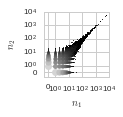

In [31]:
seaborn.set_style("whitegrid", {'axes.grid' : True})
plot_n1_vs_n2(pair_samples,'null_n1_v_n2_'+parvernull+'_NBPois',outpath,True)

In [3]:
def get_model_sample_NBPois(paras,Nsamp,Nreads):#define D region
    
    alpha_rho = paras[0]
    nfbins=800
    fmin=np.power(10,paras[3])
    rhofvec,fvec = get_rhof(alpha_rho,nfbins,fmin) 
    logfvec=np.log(fvec)
    logrhofvec=np.log(rhofvec)
    dlogf=np.diff(logfvec)/2. #two for custom trapezoid

    beta_mv= paras[1]
    alpha_mv=paras[2]
 
    m=float(Nreads)*fvec
    v=m+beta_mv*np.power(m,alpha_mv)
    pvec=1-m/v
    nvec=m*m/v/pvec
    logPn0_f=np.zeros((len(fvec),))
    Pn_f=np.empty((len(fvec),),dtype=object) #define a new Pn2_f on shifted domain at each iteration
    for find,(n,p) in enumerate(zip(nvec,pvec)):
        Pn_f[find]=nbinom(n,1-p)
        logPn0_f[find]=np.log(Pn_f[find].pmf(0))

    print('sample f and n in D')

    integ=np.exp(2*logPn0_f+logrhofvec+logfvec)
    logPnng0_d=np.log(1-np.dot(dlogf,integ[1:]+integ[:-1]))

    logPqx0_f=np.log(1-np.exp(logPn0_f))+logPn0_f
    logPq0x_f=logPn0_f+np.log(1-np.exp(logPn0_f))
    logPqxx_f=np.log(1-np.exp(logPn0_f))+np.log(1-np.exp(logPn0_f)) #since conditionals also normalize
    logPfqx0=logPqx0_f+logrhofvec
    logPfq0x=logPq0x_f+logrhofvec
    logPfqxx=logPqxx_f+logrhofvec

    Pqx0=np.trapz(np.exp(logPfqx0+logfvec),x=logfvec)
    Pq0x=np.trapz(np.exp(logPfq0x+logfvec),x=logfvec)
    Pqxx=np.trapz(np.exp(logPfqxx+logfvec),x=logfvec)

    newPqZ=Pqx0+Pq0x+Pqxx
    print(str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))
    logPf_qx0=logPfqx0-np.log(Pqx0) #don't add renormalization yet since it would cancel here anyway
    logPf_q0x=logPfq0x-np.log(Pq0x)
    logPf_qxx=logPfqxx-np.log(Pqxx)

    Pqx0/=newPqZ
    Pq0x/=newPqZ
    Pqxx/=newPqZ
    #don't renormalize Pfsq... since no longer needed

    #Sample-----------------------------------------------------------------------------

    #quadrant, q={qx0,q0x,qxx}
    q_samples=np.random.choice(range(3), Nsamp, p=(Pqx0,Pq0x,Pqxx))
    vals,counts=np.unique(q_samples,return_counts=True)
    num_qx0=counts[0]
    num_q0x=counts[1]
    num_qxx=counts[2]
    print('q samples: '+str(sum(counts))+' '+str(num_qx0)+' '+str(num_q0x)+' '+str(num_qxx))
    print('q sampled probs: '+str(num_qx0/float(sum(counts)))+' '+str(num_q0x/float(sum(counts)))+' '+str(num_qxx/float(sum(counts))))
    print('q act probs: '+str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))

    #f,n1 in x0    
    integ=np.exp(logPf_qx0+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_qx0).flatten()
    f_samples_inds=np.asarray(f_samples_inds,dtype=int)
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qx0_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qx0_samples=np.zeros((num_qx0,))
    qx0_m_samples=np.zeros((num_qx0,))
    for it,find in enumerate(find_vals):
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    qx0_pair_samples=np.hstack((qx0_samples[:,np.newaxis],np.zeros((num_qx0,1)))) 

    #f,s,n2 in 0x
    integ=np.exp(logPf_q0x+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_q0x).flatten()      
    f_samples_inds=np.sort(f_samples_inds)
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    q0x_samples=np.zeros((num_q0x,))
    q0x_f_samples=fvec[f_samples_inds]
    for it,find in enumerate(find_vals):
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    q0x_pair_samples=np.hstack((np.zeros((num_q0x,1)),q0x_samples[:,np.newaxis]))

    #f,s,n1,n2 in xx\
    integ=np.exp(logPf_qxx+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_qxx).flatten() 
    f_samples_inds=np.sort(f_samples_inds)
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qxx_f_samples=fvec[f_samples_inds]
    qxx_n1_samples=np.zeros((num_qxx,))
    qxx_n2_samples=np.zeros((num_qxx,))
    for it,find in enumerate(find_vals):
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    qxx_pair_samples=np.hstack((qxx_n1_samples[:,np.newaxis],qxx_n2_samples[:,np.newaxis]))

    f_samples=np.concatenate((qx0_f_samples,q0x_f_samples,qxx_f_samples))
    pair_samples=np.vstack((qx0_pair_samples,q0x_pair_samples,qxx_pair_samples))

    return f_samples,pair_samples

## Poisson model

In [11]:
#libraries
from scipy.stats import nbinom,poisson
from DiffExprModel_lib_tmp2clean_r import get_rhof, get_distsample,NegBinParMtr

4 cores available


In [ ]:
from infer_diffexpr_lib import import_data,get_sparserep
NreadsI=NreadsI_d
NreadsII=NreadsII_d
repfac=NreadsII/NreadsI
nfbins=500
case=3
condict={'type':'eq','fun':constr_fn,'args': (NreadsI_d,NreadsII_d,unicountvals_1_d,unicountvals_2_d,indn1_d,indn2_d,countpaircounts_d,case)}
st=time.time()
partialobjfunc=partial(get_Pn1n2_s,svec=-1,unicountvals_1=unicountvals_1_d, unicountvals_2=unicountvals_2_d, NreadsI=NreadsI_d, NreadsII=NreadsII_d, nfbins=nfbins,repfac=repfac,indn1=indn1_d ,indn2=indn2_d,countpaircounts_d=countpaircounts_d,case=case)
initparas = np.asarray([-2.191965 , 2.614699 , 1.166377,  6.559887, -9.336235])
Nfeval = 1
def callbackF(Xi):
    global Nfeval
    print('{0: 4d} {1: 3.6f} {2: 3.6f} {3: 3.6f} {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4]))
    Nfeval += 1
nullfunctol=1e-10
nullmaxiter=200
print('{0:4s} {1:9s} {2:9s} {3:9s} {4:9s}'.format('Iter', 'alph_rho', 'beta','alpha','m_total','fmin'))
outstruct_NBPois = minimize(partialobjfunc, initparas, method='SLSQP', callback=callbackF, constraints=condict,tol=1e-10,options={'ftol':nullfunctol ,'disp': True,'maxiter':nullmaxiter})
for key,value in outstruct_NBPois.items():
    print(key+':'+str(value)+'\n')
et=time.time()
print("elapsed "+str(et-st))

In [12]:
case=2
#we set fmin so that N_mouse rep is 1e7
paras=np.asarray([-2.15199494,  1.27984874,  1.02263351,  -9.73615977])
# paras=np.asarray([-2.427392,  1.267604,  1.096700, -8.11188])
alpha_rho = paras[0]
nfbins=800
fmin=np.power(10,paras[3])
rhofvec,fvec = get_rhof(alpha_rho,nfbins,fmin) 
logfvec=np.log(fvec)
logrhofvec=np.log(rhofvec)
dlogf=np.diff(logfvec)/2. #two for custom trapezoid

#number of reads: free parameter (taken to be same for both)
Nreads=1464283#1498170+1430396
#int(0.01/fmin)
Nsamp=1497221
alpha_rho = paras[0]
beta_mv= paras[1]
alpha_mv=paras[2]

In [13]:
integ=np.exp(logrhofvec+2*logfvec)
avgf_ps=np.dot(dlogf,integ[:-1]+integ[1:])
N_mouserep=1/avgf_ps
m=Nreads*fvec
v=m+beta_mv*np.power(m,alpha_mv)
pvec=1-m/v
nvec=m*m/v/pvec
logPn0_f=np.zeros((len(fvec),))
Pn_f=np.empty((len(fvec),),dtype=object) #define a new Pn2_f on shifted domain at each iteration
for find,(n,p) in enumerate(zip(nvec,pvec)):
    Pn_f[find]=nbinom(n,1-p)
#     Pn_f[find]=poisson(Nreads*fvec[find])
    logPn0_f[find]=np.log(Pn_f[find].pmf(0))
integ=np.exp(2*logPn0_f+logrhofvec+logfvec)
Pn0n0=np.dot(dlogf,integ[1:]+integ[:-1])
# Nsamp=N_mouserep*(1-Pn0n0)   

/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning:

divide by zero encountered in log



In [14]:
def get_sample_indirect(Pn_f,logfvec,logrhofvec,Nsamp):#define D region
    
    print('sample f and n in D')
    logPn0_f=np.asarray([np.log(dist.pmf(0)) for dist in Pn_f])

    integ=np.exp(2*logPn0_f+logrhofvec+logfvec)
    logPnng0_d=np.log(1-np.dot(dlogf,integ[1:]+integ[:-1]))
    
    Nimp=Nsamp#int(np.exp(logPd+logPnng0_d+np.log(N_mouserep)))

    logPqx0_f=np.log(1-np.exp(logPn0_f))+logPn0_f
    logPq0x_f=logPn0_f+np.log(1-np.exp(logPn0_f))
    logPqxx_f=np.log(1-np.exp(logPn0_f))+np.log(1-np.exp(logPn0_f)) #since conditionals also normalize
    logPfqx0=logPqx0_f+logrhofvec
    logPfq0x=logPq0x_f+logrhofvec
    logPfqxx=logPqxx_f+logrhofvec

#     logPfqx0=logPfqx0-logPd
#     logPfq0x=logPfq0x-logPd 
#     logPfqxx=logPfqxx-logPd
    # d=(logfvec[np.newaxis,:]<np.log(f0))*(logfvec[np.newaxis,:]+svec[:,np.newaxis]<np.log(f0))
#     logPfqx0+=d
#     logPfq0x+=d
#     logPfqxx+=d

    Pqx0=np.trapz(np.exp(logPfqx0+logfvec),x=logfvec)
    Pq0x=np.trapz(np.exp(logPfq0x+logfvec),x=logfvec)
    Pqxx=np.trapz(np.exp(logPfqxx+logfvec),x=logfvec)

    newPqZ=Pqx0+Pq0x+Pqxx
    print(str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))
    logPf_qx0=logPfqx0-np.log(Pqx0) #don't add renormalization yet since it would cancel here anyway
    logPf_q0x=logPfq0x-np.log(Pq0x)
    logPf_qxx=logPfqxx-np.log(Pqxx)

    Pqx0/=newPqZ
    Pq0x/=newPqZ
    Pqxx/=newPqZ
    #don't renormalize Pfsq... since no longer needed

    #Sample-----------------------------------------------------------------------------

    #quadrant, q={qx0,q0x,qxx}
    seed1=1
    np.random.seed=1.
    q_samples=np.random.choice(range(3), Nimp, p=(Pqx0,Pq0x,Pqxx))
    vals,counts=np.unique(q_samples,return_counts=True)
    num_qx0=counts[0]
    num_q0x=counts[1]
    num_qxx=counts[2]
    print('q samples: '+str(sum(counts))+' '+str(num_qx0)+' '+str(num_q0x)+' '+str(num_qxx))
    print('q sampled probs: '+str(num_qx0/float(sum(counts)))+' '+str(num_q0x/float(sum(counts)))+' '+str(num_qxx/float(sum(counts))))
    print('q act probs: '+str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))

    #f,n1 in x0    
    integ=np.exp(logPf_qx0+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_qx0).flatten()
    f_samples_inds=np.asarray(f_samples_inds,dtype=int) # +1   #handles blip ???????????????
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qx0_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qx0_samples=np.zeros((num_qx0,))
    qx0_m_samples=np.zeros((num_qx0,))
    for it,find in enumerate(find_vals):
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    qx0_pair_samples=np.hstack((qx0_samples[:,np.newaxis],np.zeros((num_qx0,1)))) 

    #f,s,n2 in 0x
    integ=np.exp(logPf_q0x+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_q0x).flatten()      
    f_samples_inds=np.sort(f_samples_inds)
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    q0x_samples=np.zeros((num_q0x,))
    q0x_f_samples=fvec[f_samples_inds]
    for it,find in enumerate(find_vals):
        samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
        q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    q0x_pair_samples=np.hstack((np.zeros((num_q0x,1)),q0x_samples[:,np.newaxis]))

    #f,s,n1,n2 in xx\
    integ=np.exp(logPf_qxx+logfvec)
    f_samples_inds=get_distsample((dlogf*(integ[1:] + integ[:-1])),num_qxx).flatten() 
    f_samples_inds=np.sort(f_samples_inds)
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qxx_f_samples=fvec[f_samples_inds]
    qxx_n1_samples=np.zeros((num_qxx,))
    qxx_n2_samples=np.zeros((num_qxx,))
    for it,find in enumerate(find_vals):
            samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
            qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
            samples=np.random.random(size=f_counts[it]) * (1-Pn_f[find].cdf(0)) + Pn_f[find].cdf(0)
            qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn_f[find].ppf(samples)
    qxx_pair_samples=np.hstack((qxx_n1_samples[:,np.newaxis],qxx_n2_samples[:,np.newaxis]))

    f_samples_imp=np.concatenate((qx0_f_samples,q0x_f_samples,qxx_f_samples))

    pair_samples_imp=np.vstack((qx0_pair_samples,q0x_pair_samples,qxx_pair_samples))
#     pair_samples=np.vstack((pair_samples_imp,np.hstack((n1_samples[:,np.newaxis],n2_samples[:,np.newaxis]))))
    pair_samples=pair_samples_imp

#     f_samples_eff=np.concatenate((f_samples_exp,f_samples_imp))
    f_samples_eff=f_samples_imp

    return f_samples_eff,pair_samples

In [20]:
f_samples_eff,pair_samples=get_sample_indirect(Pn_f,logfvec,logrhofvec,Nsamp)

sample f and n in D
0.00134705903929 0.00134705903929 0.00012541651844
q samples: 1497221 716052 714692 66477
q sampled probs: 0.478254045328 0.477345695792 0.0444002588796
q act probs: 0.477759358127 0.477759358127 0.0444812837453


/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning:

divide by zero encountered in log



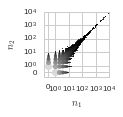

In [23]:
plot_n1_vs_n2(pd.DataFrame({'Clone_count_1':pair_samples[:,0],'Clone_count_2':pair_samples[:,1]}),'null_n1_v_n2_'+parvernull+'_Pois',outpath,True)

In [15]:
f_samples_eff,pair_samples=get_sample_indirect(Pn_f,logfvec,logrhofvec,Nsamp)

sample f and n in D
0.000928117896063 0.000928117896063 7.6028820854e-05
q samples: 1497221 718921 719347 58953
q sampled probs: 0.480170262106 0.48045478924 0.0393749486549
q act probs: 0.480326498673 0.480326498673 0.0393470026534


/home/max/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning:

divide by zero encountered in log



In [ ]:
# import plotly as py
# import plotly.offline as of
# import plotly.graph_objs as go
# of.init_notebook_mode()
# z=(d[np.newaxis,:]*(Pfs_qx0[:,slice1] + Pfs_qx0[:,slice2])).transpose()
# trace = go.Heatmap(x=svec,y=np.log10(fvec[:-1]),z=np.log10(z),zmin=-20,zmax=0)
# data=[trace]
# layout = go.Layout(title='qx0', xaxis=dict(title='s'),
#                                 yaxis=dict(title='log_{10}f'))
# fig = go.Figure(data=data, layout=layout)
# of.iplot(fig, filename='basic-heatmap')